In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

In [2]:
# Load data
df_all = pd.read_csv('dataset.csv')

In [3]:
df_all.columns

Index(['Date', 'gold', 'usd_inr', 'dxy', 'treasury_yield', 'sp500', 'vix',
       'crude', 'silver', 'btc'],
      dtype='object')

In [4]:
# Convert 'Date' to datetime
df_all['Date'] = pd.to_datetime(df_all['Date'], errors='coerce')

# Set the 'Date' column as index
df_all.set_index('Date', inplace=True)

# Check the head and index type
print(df_all.head())
print(df_all.index)

                   gold    usd_inr        dxy  treasury_yield        sp500  \
Date                                                                         
2015-01-02  1186.000000  63.028000  91.080002           2.123  2058.199951   
2015-01-05  1203.900024  63.278000  91.379997           2.039  2020.579956   
2015-01-06  1219.300049  63.338001  91.500000           1.963  2002.609985   
2015-01-07  1210.599976  63.568001  91.889999           1.954  2025.900024   
2015-01-08  1208.400024  63.272999  92.370003           2.016  2062.139893   

                  vix      crude     silver         btc  
Date                                                     
2015-01-02  17.790001  52.689999  15.734000  315.032013  
2015-01-05  19.920000  50.040001  16.179001  274.473999  
2015-01-06  21.120001  47.930000  16.603001  286.188995  
2015-01-07  19.309999  48.650002  16.510000  294.337006  
2015-01-08  17.010000  48.790001  16.351000  283.348999  
DatetimeIndex(['2015-01-02', '2015-01-05', '201

In [5]:
# Convert all other columns to numeric
for col in df_all.columns:
    if col != 'Date':
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

In [6]:
# Feature Engineering

df_all['target'] = (df_all['gold'].shift(-1) > df_all['gold']).astype(int)

lags = {
    'gold': [1, 2, 3, 5],
    'usd_inr': [1, 3],
    'dxy': [1, 2],
    'treasury_yield': [1],
    'sp500': [1, 3, 5],
    'vix': [1, 2],
    'crude': [1, 3],
    'silver': [1, 2],
    'btc': [1, 3]
}

for col, lag_days in lags.items():
    for lag in lag_days:
        df_all[f'{col}_lag{lag}'] = df_all[col].shift(lag)

rolling_windows = [5, 10]
for window in rolling_windows:
    df_all[f'gold_ma{window}'] = df_all['gold'].rolling(window).mean()
    df_all[f'gold_std{window}'] = df_all['gold'].rolling(window).std()

df_all['gold_silver_ratio'] = df_all['gold'] / df_all['silver']
df_all['gold_crude_ratio'] = df_all['gold'] / df_all['crude']
df_all['gold_dxy_ratio'] = df_all['gold'] / df_all['dxy']
df_all['gold_btc_ratio'] = df_all['gold'] / df_all['btc']

df_all.dropna(inplace=True)

# Features & target
features = [col for col in df_all.columns if col not in ['target', 'gold']]
X = df_all[features]
y = df_all['target']

In [7]:
# TRAIN-TEST SPLIT
train_size = int(len(df_all) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [10]:
# SMOTE on training set
from imblearn.over_sampling import SMOTE

# Apply SMOTE and keep column names
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Restore column names
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)

In [11]:
# MODEL
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_res, y_train_res)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:32:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [12]:
# EVALUATION
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.46641074856046066
ROC AUC: 0.4594836058250692
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.62      0.51       234
           1       0.52      0.34      0.41       287

    accuracy                           0.47       521
   macro avg       0.48      0.48      0.46       521
weighted avg       0.48      0.47      0.46       521

Confusion Matrix:
 [[146  88]
 [190  97]]


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:42:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.6}
Accuracy: 0.43953934740882916
ROC AUC: 0.44737038029720955
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.74      0.54       234
           1       0.48      0.20      0.28       287

    accuracy                           0.44       521
   macro avg       0.45      0.47      0.41       521
weighted avg       0.46      0.44      0.40       521

Confusion Matrix:
 [[172  62]
 [230  57]]


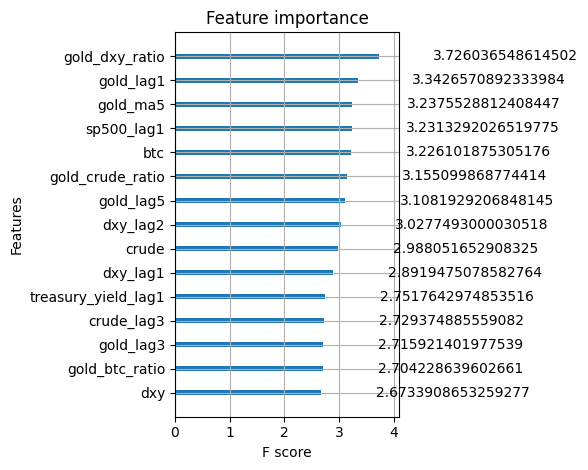

In [15]:
#Hyperparameter tuning with RandomizedSearchCV

# Randomized Search Parameter Grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5],
}

xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=2,
    random_state=42
)

# Fit search
random_search.fit(X_train_res, y_train_res)

# Best model
best_xgb = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Predictions
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot feature importance
plot_importance(best_xgb, max_num_features=15, importance_type='gain')
plt.tight_layout()
plt.show()

In [16]:
#Rebuilding the model with only 15 important features.

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_res, y_train_res)

# Extract importances with correct shape
importances = pd.Series(xgb.feature_importances_, index=X_train.columns)

# Pick top 20
top_features = importances.sort_values(ascending=False).head(20).index.tolist()


In [17]:
# Filter data
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Retrain model
xgb_reduced = XGBClassifier(random_state=42)
xgb_reduced.fit(X_train_reduced, y_train)

# Predict and evaluate
y_pred = xgb_reduced.predict(X_test_reduced)
y_proba = xgb_reduced.predict_proba(X_test_reduced)[:, 1]

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.45681381957773515
ROC AUC: 0.45488996098752194
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.74      0.55       234
           1       0.52      0.23      0.31       287

    accuracy                           0.46       521
   macro avg       0.48      0.48      0.43       521
weighted avg       0.48      0.46      0.42       521

Confusion Matrix:
 [[173  61]
 [222  65]]
